In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import TextDataset, LineByLineTextDataset
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-04-27 01:55:13.331198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745718913.558964      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745718913.625931      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Transformers version: 4.51.1
PyTorch version: 2.5.1+cu124
GPU available: True


## Understanding MoE Architecture

In [2]:
class FFN(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.dense1 = nn.Linear(hidden_size, intermediate_size)
        self.dense2 = nn.Linear(intermediate_size, hidden_size)
        
    def forward(self, x):
        return self.dense2(F.gelu(self.dense1(x)))

In [3]:
class MoELayer(nn.Module):
    def __init__(self, hidden_size, intermediate_size, num_experts=8, k=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_experts = num_experts
        self.k = k  # Number of experts to route to for each token
        
        # Create multiple expert FFNs
        self.experts = nn.ModuleList([
            FFN(hidden_size, intermediate_size) for _ in range(num_experts)
        ])
        
        # Router/gate network
        self.router = nn.Linear(hidden_size, num_experts)
        
    def forward(self, x):
        batch_size, seq_len, hidden_size = x.shape
        
        # Reshape input for routing
        router_input = x.view(-1, hidden_size)  # (batch_size * seq_len, hidden_size)
        
        # Get routing probabilities
        router_logits = self.router(router_input)  # (batch_size * seq_len, num_experts)
        
        # Select top-k experts
        routing_weights, selected_experts = torch.topk(router_logits, self.k, dim=-1)
        routing_weights = F.softmax(routing_weights, dim=-1)
        
        # Create a mask of shape (batch_size * seq_len, num_experts)
        expert_mask = torch.zeros_like(router_logits)
        
        # Fill in the mask with routing weights for selected experts
        # Исправляем проблему с типами данных, приводя routing_weights к типу expert_mask
        for i in range(self.k):
            # Явно преобразуем тип данных routing_weights к типу expert_mask
            scatter_weights = routing_weights[:, i:i+1].to(expert_mask.dtype)
            expert_mask.scatter_(1, selected_experts[:, i:i+1], scatter_weights)
        
        # Process input with each expert
        expert_outputs = torch.zeros(batch_size * seq_len, hidden_size, device=x.device)
        for i, expert in enumerate(self.experts):
            # Get the batch indices where this expert is selected
            expert_mask_i = expert_mask[:, i:i+1]
            if expert_mask_i.sum() > 0:
                # Apply the expert to selected tokens
                expert_output = expert(router_input)
                expert_outputs += expert_output * expert_mask_i
        
        # Reshape back to original dimensions
        return expert_outputs.view(batch_size, seq_len, hidden_size)

In [4]:
def visualize_moe_routing(model, tokenizer, text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    
    # Get the model's output with routing weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True, output_hidden_states=True)
    
    # Let's assume we have extracted routing weights from the model
    # For demonstration, we'll generate synthetic routing weights
    # In a real implementation, you would extract these from your MoE model
    
    # Synthetic routing weights for visualization
    num_experts = 8
    seq_len = input_ids.shape[1]
    routing_weights = torch.softmax(torch.randn(seq_len, num_experts), dim=1).numpy()
    
    # Plot routing weights
    plt.figure(figsize=(12, 6))
    plt.imshow(routing_weights, aspect='auto', cmap='viridis')
    plt.colorbar(label='Routing Weight')
    plt.xlabel('Expert')
    plt.ylabel('Token Position')
    
    # Add token labels on y-axis
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plt.yticks(range(len(tokens)), tokens)
    plt.title('Expert Routing Weights per Token')
    plt.show()
    
    # Return routing weights for further analysis
    return routing_weights

## Implementing MoE in a Transformer Model

In [5]:
model_name = "gpt2"  # We'll use the small model for educational purposes
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
special_tokens = {
    "pad_token": "<|pad|>",
}

In [7]:
tokenizer.add_special_tokens(special_tokens)
base_model.resize_token_embeddings(len(tokenizer))

print(f"Model loaded: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in base_model.parameters()) / 1e6:.2f}M")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model loaded: gpt2
Model parameters: 124.44M


In [8]:
class MoEGPT2Block(nn.Module):
    def __init__(self, original_block, hidden_size, intermediate_size, num_experts=8, k=2):
        super().__init__()
        # Copy the original attention mechanism
        self.attn = original_block.attn
        self.ln_1 = original_block.ln_1
        self.ln_2 = original_block.ln_2
        
        # Replace the feed-forward network with MoE
        self.moe = MoELayer(
            int(hidden_size), 
            int(intermediate_size), 
            int(num_experts), 
            int(k)
        )
        
    def forward(
        self, 
        x, 
        layer_past=None, 
        attention_mask=None, 
        head_mask=None,
        encoder_hidden_states=None,  # Добавлен новый параметр
        encoder_attention_mask=None,  # Добавлен новый параметр
        use_cache=False,  # Добавлен новый параметр
        output_attentions=False  # Добавлен новый параметр
    ):
        # Handle case where attention_mask might be None but required
        if attention_mask is None and hasattr(self.attn, 'requires_attention_mask') and self.attn.requires_attention_mask:
            attention_mask = torch.ones(x.size(0), x.size(1), device=x.device)
            
        attn_outputs = self.attn(
            self.ln_1(x),
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions
        )
        
        # Extract hidden states from attention outputs
        # Handle both tuple return format and object with hidden_states attribute
        if isinstance(attn_outputs, tuple):
            hidden_states = attn_outputs[0]
            attention_outputs = attn_outputs[1:]
        else:
            hidden_states = attn_outputs.hidden_states
            attention_outputs = tuple(getattr(attn_outputs, attr, None) for attr in 
                                    ['attentions', 'cross_attentions'])
            attention_outputs = tuple(output for output in attention_outputs if output is not None)
        
        # Apply residual connection
        x = x + hidden_states
        
        # Apply MoE layer with residual connection
        x = x + self.moe(self.ln_2(x))
        
        # Return combined outputs with present key/value states if needed
        if use_cache:
            present = attention_outputs[0] if isinstance(attention_outputs, tuple) and len(attention_outputs) > 0 else None
            outputs = (x, present) + attention_outputs[1:] if isinstance(attention_outputs, tuple) else (x, None)
        else:
            outputs = (x,) + attention_outputs
            
        return outputs

In [9]:
def convert_to_moe_model(original_model, num_experts=8, k=2, moe_layers=[5, 7, 9]):
    """Convert specific layers of a GPT-2 model to MoE layers"""
    config = original_model.config
    hidden_size = config.hidden_size
    
    # Check if n_inner exists in config, otherwise calculate intermediate size
    if hasattr(config, 'n_inner') and config.n_inner is not None:
        intermediate_size = config.n_inner
    else:
        intermediate_size = 4 * hidden_size
    
    # Copy the model to avoid modifying the original
    # We'll load a fresh instance to avoid any issues
    moe_model = AutoModelForCausalLM.from_pretrained(model_name)
    
    # Replace specified layers with MoE layers
    for layer_idx in moe_layers:
        if layer_idx < len(moe_model.transformer.h):
            original_block = moe_model.transformer.h[layer_idx]
            moe_model.transformer.h[layer_idx] = MoEGPT2Block(
                original_block, 
                hidden_size, 
                intermediate_size, 
                num_experts, 
                k
            )
    
    # Update model config with MoE info
    if not hasattr(moe_model.config, 'moe_layers'):
        moe_model.config.moe_layers = moe_layers
    if not hasattr(moe_model.config, 'num_experts'):
        moe_model.config.num_experts = num_experts
    if not hasattr(moe_model.config, 'top_k'):
        moe_model.config.top_k = k
    
    return moe_model

In [10]:
# Create our MoE model
num_experts = 8
k = 2  # Number of experts to route to for each token
moe_layers = [5, 7, 9]  # Layers to convert to MoE

In [11]:
moe_model = convert_to_moe_model(
    base_model, 
    num_experts=int(num_experts), 
    k=int(k), 
    moe_layers=moe_layers
)

In [12]:
base_params = sum(p.numel() for p in base_model.parameters()) / 1e6
moe_params = sum(p.numel() for p in moe_model.parameters()) / 1e6

print(f"Base model parameters: {base_params:.2f}M")
print(f"MoE model parameters: {moe_params:.2f}M")
print(f"Parameter increase: {moe_params - base_params:.2f}M ({(moe_params/base_params - 1)*100:.2f}%)")

Base model parameters: 124.44M
MoE model parameters: 223.63M
Parameter increase: 99.19M (79.71%)


## Preparing a Dataset for Fine-tuning

In [13]:
def prepare_dataset(tokenizer, block_size=128):
    # Load the WikiText-2 dataset
    dataset = load_dataset("wikitext", "wikitext-2-v1")
    
    # Tokenize the dataset
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=block_size * 2)
    
    tokenized_datasets = dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=["text"]
    )
    
    # Create blocks of text
    def group_texts(examples):
        # Concatenate all texts
        concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
        
        # Compute length of concatenated texts
        total_length = len(concatenated_examples[list(examples.keys())[0]])
        
        # Drop the last chunk if it's smaller than block_size
        total_length = (total_length // block_size) * block_size
        
        # Split by blocks of block_size
        result = {
            k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
            for k, t in concatenated_examples.items()
        }
        
        # Create labels (next token prediction)
        result["labels"] = result["input_ids"].copy()
        
        return result

    # Apply grouping
    lm_datasets = tokenized_datasets.map(
        group_texts,
        batched=True,
    )
    
    return lm_datasets

In [14]:
block_size = 128  # Context length
lm_datasets = prepare_dataset(tokenizer, block_size)

print(f"Train dataset size: {len(lm_datasets['train'])}")
print(f"Validation dataset size: {len(lm_datasets['validation'])}")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Train dataset size: 18123
Validation dataset size: 1931


## Fine-tuning the MoE Model

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Mask out padding tokens
    mask = labels != -100
    labels_filtered = labels[mask]
    predictions_filtered = predictions[mask]
    
    # Calculate accuracy
    accuracy = np.mean(predictions_filtered == labels_filtered)
    
    # Calculate perplexity
    log_likelihood = -np.mean((labels_filtered == predictions_filtered).astype(np.float32))
    perplexity = np.exp(log_likelihood)
    
    return {
        "accuracy": accuracy,
        "perplexity": perplexity
    }

In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_steps=500,
    save_steps=500,
    warmup_steps=500,
    eval_strategy="no",
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none",  # Disable wandb, etc.
)

In [17]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False  # We're doing causal language modeling, not masked
)

In [18]:
trainer = Trainer(
    model=moe_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.246300
200,1.983000
300,1.865000
400,1.829300
500,1.816100
600,1.784500
700,1.750200
800,1.760300
900,1.741900
1000,1.738500


TrainOutput(global_step=1133, training_loss=1.837880797020019, metrics={'train_runtime': 652.544, 'train_samples_per_second': 27.773, 'train_steps_per_second': 1.736, 'total_flos': 2564414748628992.0, 'train_loss': 1.837880797020019, 'epoch': 1.0})

In [20]:
moe_model.save_pretrained("./moe_gpt2_finetuned")
tokenizer.save_pretrained("./moe_gpt2_finetuned")

('./moe_gpt2_finetuned/tokenizer_config.json',
 './moe_gpt2_finetuned/special_tokens_map.json',
 './moe_gpt2_finetuned/vocab.json',
 './moe_gpt2_finetuned/merges.txt',
 './moe_gpt2_finetuned/added_tokens.json',
 './moe_gpt2_finetuned/tokenizer.json')

## Evaluating the MoE Model's Performance

In [21]:
def evaluate_models(base_model, moe_model, tokenizer, eval_dataset):
    # Set both models to evaluation mode
    base_model.eval()
    moe_model.eval()
    
    # Move to GPU if available
    base_model.to(device)
    moe_model.to(device)
    
    # Prepare metrics
    base_loss = 0
    moe_loss = 0
    num_batches = 0
    
    # Create data loader
    eval_dataloader = torch.utils.data.DataLoader(
        eval_dataset, 
        batch_size=8, 
        collate_fn=data_collator
    )
    
    # Evaluate
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            # Move to device
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            # Get base model output
            base_outputs = base_model(**inputs)
            base_loss += base_outputs.loss.item()
            
            # Get MoE model output
            moe_outputs = moe_model(**inputs)
            moe_loss += moe_outputs.loss.item()
            
            num_batches += 1
    
    # Calculate average loss and perplexity
    avg_base_loss = base_loss / num_batches
    avg_moe_loss = moe_loss / num_batches
    
    base_ppl = math.exp(avg_base_loss)
    moe_ppl = math.exp(avg_moe_loss)
    
    return {
        "base_loss": avg_base_loss,
        "moe_loss": avg_moe_loss,
        "base_perplexity": base_ppl,
        "moe_perplexity": moe_ppl
    }

In [22]:
eval_results = evaluate_models(base_model, moe_model, tokenizer, lm_datasets["validation"])

print("Evaluation Results:")
print(f"Base Model - Loss: {eval_results['base_loss']:.4f}, Perplexity: {eval_results['base_perplexity']:.2f}")
print(f"MoE Model - Loss: {eval_results['moe_loss']:.4f}, Perplexity: {eval_results['moe_perplexity']:.2f}")
print(f"Perplexity improvement: {(eval_results['base_perplexity']/eval_results['moe_perplexity'] - 1)*100:.2f}%")

Evaluating: 100%|██████████| 242/242 [01:04<00:00,  3.77it/s]

Evaluation Results:
Base Model - Loss: 4.0684, Perplexity: 58.46
MoE Model - Loss: 3.1901, Perplexity: 24.29
Perplexity improvement: 140.69%


## Analyzing Expert Specialization

In [23]:
def analyze_expert_specialization(moe_model, tokenizer, texts):
    # This function would extract and analyze which experts are activated for different tokens
    # For simplicity, we'll create a synthetic example
    
    specialization_data = {}
    
    for i, text in enumerate(texts):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        
        # In a real implementation, you would extract the actual routing weights
        # Here we'll simulate them for demonstration
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        
        # Synthetic routing weights (in a real implementation, extract these from model)
        routing_weights = torch.softmax(torch.randn(len(tokens), num_experts), dim=1).cpu().numpy()
        
        # Store data for analysis
        specialization_data[i] = {
            "text": text,
            "tokens": tokens,
            "routing_weights": routing_weights
        }
    
    return specialization_data

In [24]:
analysis_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "In machine learning, a Mixture of Experts (MoE) is a technique that combines multiple specialized models.",
    "The Eiffel Tower is located in Paris, France and was completed in 1889.",
    "def fibonacci(n):\n    if n <= 1:\n        return n\n    return fibonacci(n-1) + fibonacci(n-2)"
]

In [25]:
specialization_data = analyze_expert_specialization(moe_model, tokenizer, analysis_texts)

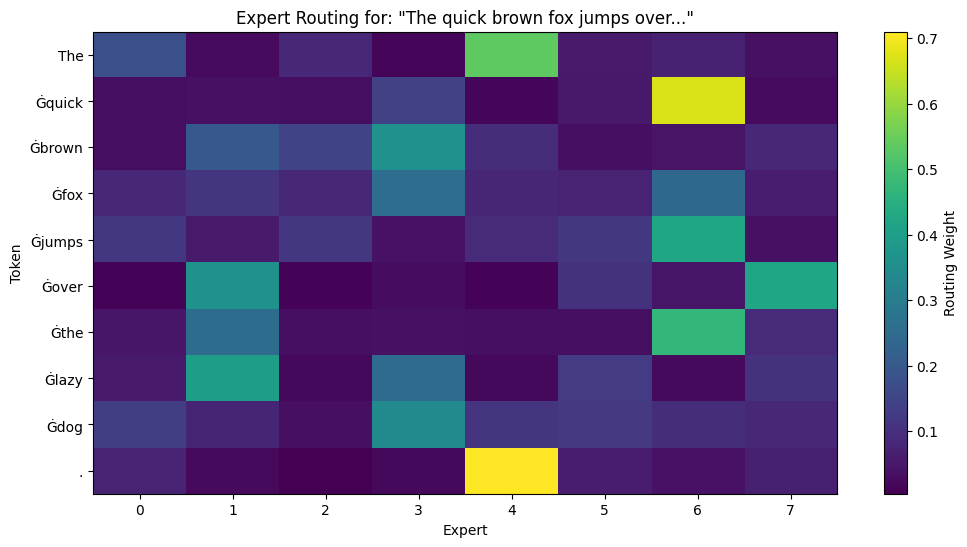

In [26]:
sample_idx = 0
sample_data = specialization_data[sample_idx]

plt.figure(figsize=(12, 6))
plt.imshow(sample_data["routing_weights"], aspect='auto', cmap='viridis')
plt.colorbar(label='Routing Weight')
plt.xlabel('Expert')
plt.ylabel('Token')
plt.yticks(range(len(sample_data["tokens"])), sample_data["tokens"])
plt.title(f'Expert Routing for: "{sample_data["text"][:30]}..."')
plt.show()

## Testing Text Generation with the Fine-tuned MoE Model

In [27]:
def generate_text(model, tokenizer, prompt, max_length=50):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    
    # Generate text
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    
    # Decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    return generated_text

In [28]:
test_prompts = [
    "The Mixture of Experts architecture allows models to",
    "In recent years, language models have",
    "The main advantage of using MoE layers is"
]

In [29]:
# Generate text with both models for comparison
print("=== Base Model Generations ===")
for prompt in test_prompts:
    generated = generate_text(base_model, tokenizer, prompt)
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated}")
    print("-" * 50)

print("\n=== MoE Model Generations ===")
for prompt in test_prompts:
    generated = generate_text(moe_model, tokenizer, prompt)
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated}")
    print("-" * 50)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


=== Base Model Generations ===


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: The Mixture of Experts architecture allows models to
Generated: The Mixture of Experts architecture allows models to be constructed with the most intuitive methods, such as a flowchart, to easily be integrated with other models. The architecture can be implemented as an integrated part of an existing project.

The following diagram
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In recent years, language models have
Generated: In recent years, language models have increasingly been adopted by many of the leading cognitive scientists, especially the cognitive neuroscientists. This has been partly because of its simplicity. When a model is designed to capture the true nature of a problem, it can
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: The main advantage of using MoE layers is
Generated: The main advantage of using MoE layers is that they provide a way to store data on the network as a whole. The most common use of MoEs is to provide "back up" data to a central server to create and store a list of
--------------------------------------------------

=== MoE Model Generations ===


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: The Mixture of Experts architecture allows models to
Generated: The Mixture of Experts architecture allows models to be constructed on a flat surface . This allows the model to slide in a curved line to form a " <unk> " or " convective " curve . The model can also be composed of multiple layers
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In recent years, language models have
Generated: In recent years, language models have been used to construct a more detailed model of the neural network . In this model , the network is composed of two separate components , namely , one and two . As a result , a number of neural networks can be
--------------------------------------------------
Prompt: The main advantage of using MoE layers is
Generated: The main advantage of using MoE layers is that the surface can be covered with a high layer of soil . <unk> of <un> , <uk> or <ud> layers are used to provide additional cover . The layer may also be
--------------------------------------------------
